In [1]:
# ANN for predicting demand/capasity ratio

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize

import visualkeras as vs

import numpy as np
import pandas as pd
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [2]:
df = pd.read_csv('C:/Users/febyf/Documents/TGA FEBY/SAP HASIL RUNNING/DOUBLE HOWE/CSV/Rekap Data/DATA KEAMANAN TUNGGAL')

In [3]:
df

,Panjang,Kecepatan Angin,Sudut,Aman Terhadap Penampang
0,6600,1,15,Aman
1,6600,1,20,Aman
2,6600,1,25,Aman
3,6600,1,30,Aman
4,6600,1,35,Aman
...,...,...,...,...
1045,7800,50,25,Tidak Aman
1046,7800,50,30,Tidak Aman
1047,7800,50,35,Tidak Aman
1048,7800,50,40,Tidak Aman


In [4]:
data = df

In [5]:
#Split data menjadi input dan output
x = data.iloc[:, [0, 1, 2]].values      # input
y = data.iloc[:, 3 ].values             # output

In [6]:
x

array([[6600,    1,   15],
       [6600,    1,   20],
       [6600,    1,   25],
       ...,
       [7800,   50,   35],
       [7800,   50,   40],
       [7800,   50,   45]], dtype=int64)

# CLEANING DATA

In [7]:
#simpleimputer : untuk menangani nilai hilang
#missingvalues : menentukan apa yang harus dianggap oleh imputer sebagai nilai yang hilang dengan ditulis 'np.nan'
#mostfrequent  : imuter mengganti 'np.nan' dengan nilai yang paling sering muncul pada kolom 'np.nan' berada


imputer = SimpleImputer(missing_values = np.nan,strategy = 'most_frequent')

In [8]:
#mengubah y menjadi array 2D dengan satu kolom dan jumlah baris
y = y.reshape(-1, 1)
y

array([['Aman'],
       ['Aman'],
       ['Aman'],
       ...,
       ['Tidak Aman'],
       ['Tidak Aman'],
       ['Tidak Aman']], dtype=object)

In [9]:
#fit_transform adalah metode dari imputer yang melakukan dua langkah: fit dan transform
#fit adalah proses dimana imputer belajar tentang data, lebih spesifik lagi, belajar nilai yang akan digunakan untuk mengganti nilai yang hilang
#transform adalah proses penggantian nilai yang hilang dengan nilai yang telah dipelajari (fit).

x = imputer.fit_transform(x)
y = imputer.fit_transform(y)

In [10]:
x

array([[6600,    1,   15],
       [6600,    1,   20],
       [6600,    1,   25],
       ...,
       [7800,   50,   35],
       [7800,   50,   40],
       [7800,   50,   45]], dtype=int64)

# Encoding Dataset
Converting string data to numerical values so I can process the data

In [11]:
#digunakan untuk memilih semua kolom dalam DataFrame data yang tipe datanya adalah 'object' (string atau teks)
col_obj = data.select_dtypes(include = 'object').columns
col_obj

Index(['Aman Terhadap Penampang'], dtype='object')

In [12]:
#LabelEncoder dari pustaka scikit-learn untuk mengubah label kategorikal dalam array y menjadi representasi numerik.
le1 = LabelEncoder()
y[:, -1] = le1.fit_transform(y[:, -1])
y[:, -1]

array([0, 0, 0, ..., 1, 1, 1], dtype=object)

In [13]:
print(y)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


# Feature Scaling

In [14]:
#StandardScaler() untuk menormalkan atau menstandarisasi fitur dalam array x. Proses standarisasi mengubah data sehingga distribusinya memiliki rata-rata 0 dan standar deviasi 1

sc = StandardScaler()
x = sc.fit_transform(x)


In [15]:
print(x)

[[-1.22474487 -1.69774938 -1.5       ]
 [-1.22474487 -1.69774938 -1.        ]
 [-1.22474487 -1.69774938 -0.5       ]
 ...
 [ 1.22474487  1.69774938  0.5       ]
 [ 1.22474487  1.69774938  1.        ]
 [ 1.22474487  1.69774938  1.5       ]]


# Splitting Data to Train and Test Sets

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [17]:
x_train

array([[-1.22474487,  1.07408634, -1.        ],
       [-1.22474487,  0.93549455, -1.5       ],
       [ 0.        ,  0.10394384, -0.5       ],
       ...,
       [-1.22474487, -0.5197192 , -0.5       ],
       [ 1.22474487,  1.69774938, -1.        ],
       [ 1.22474487, -0.17323973,  1.5       ]])

In [18]:
#digunakan untuk mengonversi data pelatihan x_train dan y_train menjadi array NumPy dan mengubah tipe data elemennya menjadi float32
#Mengonversi data ke float32 dapat mengurangi penggunaan memori dan meningkatkan kecepatan pemrosesan,
x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

<Axes: xlabel='Aman Terhadap Penampang', ylabel='count'>

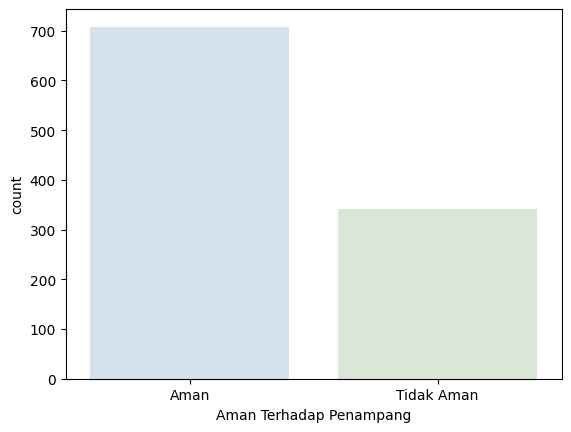

In [19]:
#countplot berguna untuk menampilkan distribusi frekuensi dari variabel kategorikal.
cols= ["#cfe2f3","#d9ead3"]
sns.countplot(x= data["Aman Terhadap Penampang"], palette= cols)

# Training Models

In [20]:
aman = data['Aman Terhadap Penampang'].value_counts()['Aman']
aman

708

In [21]:
tidak_aman = data['Aman Terhadap Penampang'].value_counts()['Tidak Aman']
tidak_aman

342

In [22]:
#x_train.shape[1] secara khusus mengembalikan nilai yang menunjukkan berapa banyak fitur (kolom) yang ada dalam data pelatihan x_train.
x_train.shape[1]

3

In [23]:
#Early stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_dim=x_train.shape[1]))


model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

model.add(Flatten())

opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(x_train, y_train, batch_size = 26, epochs = 100, callbacks=[early_stopping], validation_split=0.3)



Epoch 1/100


20/20 [==============================] - 1s 12ms/step - loss: 0.6930 - accuracy: 0.6809 - val_loss: 0.6928 - val_accuracy: 0.6787
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.6926 - val_loss: 0.6925 - val_accuracy: 0.6787
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.6926 - val_loss: 0.6922 - val_accuracy: 0.6787
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.6926 - val_loss: 0.6919 - val_accuracy: 0.6787
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.6926 - val_loss: 0.6915 - val_accuracy: 0.6787
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.6926 - val_loss: 0.6912 - val_accuracy: 0.6787
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.6926 - val_loss: 0.6908 - val_accuracy: 0.6787
Epoch 8/1

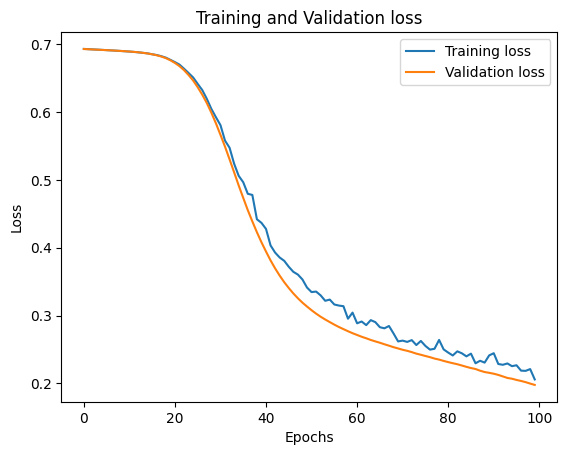

In [24]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

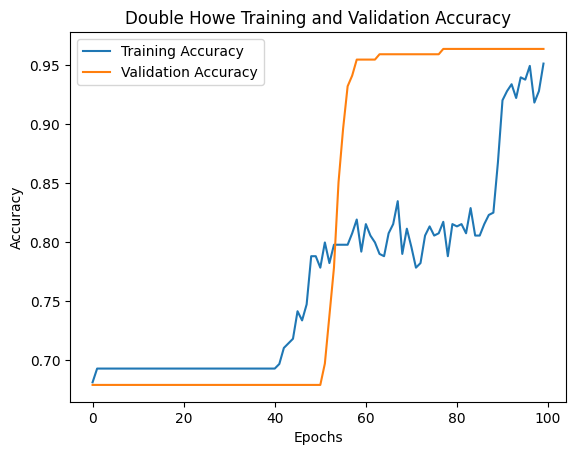

In [26]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], label='Training Accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], label='Validation Accuracy')

plt.title('Double Howe Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
x_test = np.asarray(x_test).astype('float32')

In [ ]:
y_pred = model.predict(sc.transform([[6600, 35, 15]]))
y_pred_classes = (y_pred > 0.5).astype(int)
y_pred_classes 

# Predict New Data

In [ ]:
#Prediksid data baru

Kecepatan = []
Sudut = []
Panjang = []
CFSR = []

N_batang_bawah = 6

for segment in range (1100,1400,100):
    panjang = segment * N_batang_bawah
    for kec_angin in range (10, 501, 5):
        kec_angin = kec_angin/10   
        for sudut in range (15, 46, 1):

            Kecepatan.append(kec_angin)
            Sudut.append(sudut)
            Panjang.append(panjang)
            y_pred = model.predict(sc.transform([[panjang, kec_angin, sudut]]))
            y_pred_classes = (y_pred > 0.5).astype(int)
            CFSR.append(y_pred_classes)

data ={
    'Panjang' : Panjang,
    'Kecepatan Angin': Kecepatan,
    'Sudut' : Sudut,
    'Aman Terhadap Penampang' : CFSR
} 

data = pd.DataFrame(data)

In [ ]:
data

In [ ]:
data.to_csv('C:/Users/febyf/Documents/SAP 25 TES/ANN Double Howe Baru')